In [14]:
pip install -U pip setuptools wheel pandas numpy matplotlib seaborn scikit-learn xgboost shap lime jupyter ipywidgets tqdm


  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [15]:
pip install --upgrade shap


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install xgboost==1.7.6


  Using cached xgboost-1.7.6-py3-none-win_amd64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1
Note: you may need to restart the kernel to use updated packages.


In [17]:
# ==========================================================
# 1. Configuração, Carregamento e Preparação dos Dados
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import shap
import lime
import lime.lime_tabular

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# ----------------------------------------------------------
# Carregar dados
file_path = 'https://raw.githubusercontent.com/RaphaelRAY/airbnb-rating-ml/refs/heads/main/data/processed/listings_Encode.csv'
df = pd.read_csv(file_path)

print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

# Limpeza e seleção
cols_to_drop = [
    'review_scores_rating', 
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
df = df[df['price'] > 0]

# Log-transform do preço
df['price'] = np.log1p(df['price'])

# Clipping (remove extremos)
df['price'] = df['price'].clip(
    lower=df['price'].quantile(0.01),
    upper=df['price'].quantile(0.99)
)

# Features derivadas úteis
if 'accommodates' in df.columns and 'bathrooms' in df.columns and 'bedrooms' in df.columns:
    df['bath_per_bedroom'] = df['bathrooms'] / (df['bedrooms'] + 1)

# Separar variáveis
X = df.drop('price', axis=1)
y = df['price']

X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]}")

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Dataset carregado com 41724 linhas e 40 colunas.
Treino: 33379 | Teste: 8345


In [18]:
# ==========================================================
# 2. Modelagem e Avaliação
# ==========================================================

models = {}
results = []

def evaluate_model(model, X_test, y_test, model_name):
    # Avaliação no log (mesma escala do treino)
    y_pred_log = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
    mae = mean_absolute_error(y_test, y_pred_log)
    r2 = r2_score(y_test, y_pred_log)
    results.append({'Modelo': model_name, 'RMSE(log)': rmse, 'MAE(log)': mae, 'R²': r2})
    print(f"--- {model_name} ---\nRMSE(log): {rmse:.4f}, MAE(log): {mae:.4f}, R²: {r2:.4f}")
    return model

# ----------------------------------------------------------
# Regressão Linear
print("\nTreinando Regressão Linear...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models['LinearRegression'] = evaluate_model(lr, X_test_scaled, y_test, 'Regressão Linear')

# ----------------------------------------------------------
# Random Forest
print("\nTreinando Random Forest...")
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, n_iter=5,
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
search_rf.fit(X_train_scaled, y_train)
best_rf = search_rf.best_estimator_
models['RandomForestRegressor'] = evaluate_model(best_rf, X_test_scaled, y_test, 'Random Forest')
print(f"Melhores hiperparâmetros RF: {search_rf.best_params_}")

# ----------------------------------------------------------
# XGBoost
print("\nTreinando XGBoost...")
param_dist_xgb = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 2]
}
xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist_xgb, n_iter=5,
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
search_xgb.fit(X_train_scaled, y_train)
best_xgb = search_xgb.best_estimator_
models['XGBRegressor'] = evaluate_model(best_xgb, X_test_scaled, y_test, 'XGBoost')
print(f"Melhores hiperparâmetros XGB: {search_xgb.best_params_}")




Treinando Regressão Linear...
--- Regressão Linear ---
RMSE(log): 0.5588, MAE(log): 0.4238, R²: 0.4147

Treinando Random Forest...
--- Random Forest ---
RMSE(log): 0.4683, MAE(log): 0.3428, R²: 0.5890
Melhores hiperparâmetros RF: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}

Treinando XGBoost...
--- XGBoost ---
RMSE(log): 0.4491, MAE(log): 0.3306, R²: 0.6220
Melhores hiperparâmetros XGB: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [19]:
# ==========================================================
# 3. Escolha do melhor modelo
# ==========================================================

# Constrói dataframe de resultados
results_df = pd.DataFrame(results)

# Identifica o melhor modelo
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Modelo']

# Busca o modelo exato pelo nome
best_model = None
if 'Regressão Linear' in best_model_name:
    best_model = models['LinearRegression']
elif 'Random Forest' in best_model_name:
    best_model = models['RandomForestRegressor']
elif 'XGBoost' in best_model_name:
    best_model = models['XGBRegressor']
else:
    raise ValueError("Nome do modelo não reconhecido.")

print(f"\nMelhor modelo: {best_model_name}")
print(results_df.sort_values('R²', ascending=False).reset_index(drop=True))





Melhor modelo: XGBoost
             Modelo  RMSE(log)  MAE(log)        R²
0           XGBoost   0.449095  0.330610  0.621996
1     Random Forest   0.468280  0.342770  0.589011
2  Regressão Linear   0.558815  0.423775  0.414731


In [20]:
# ==========================================================
# 4. Métricas no preço real (R$)
# ==========================================================

y_pred_real = np.expm1(best_model.predict(X_test_scaled))
y_real = np.expm1(y_test)

rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))
mae_real = mean_absolute_error(y_real, y_pred_real)
r2_real = r2_score(y_real, y_pred_real)

print(f"\nMétricas em preço real (R$):")
print(f"RMSE ≈ R$ {rmse_real:,.2f}")
print(f"MAE  ≈ R$ {mae_real:,.2f}")
print(f"R²   ≈ {r2_real:.3f}")



Métricas em preço real (R$):
RMSE ≈ R$ 372.00
MAE  ≈ R$ 176.78
R²   ≈ 0.499



Gerando SHAP Summary Plot (versão compatível)...


 93%|=================== | 463/500 [00:11<00:00]       

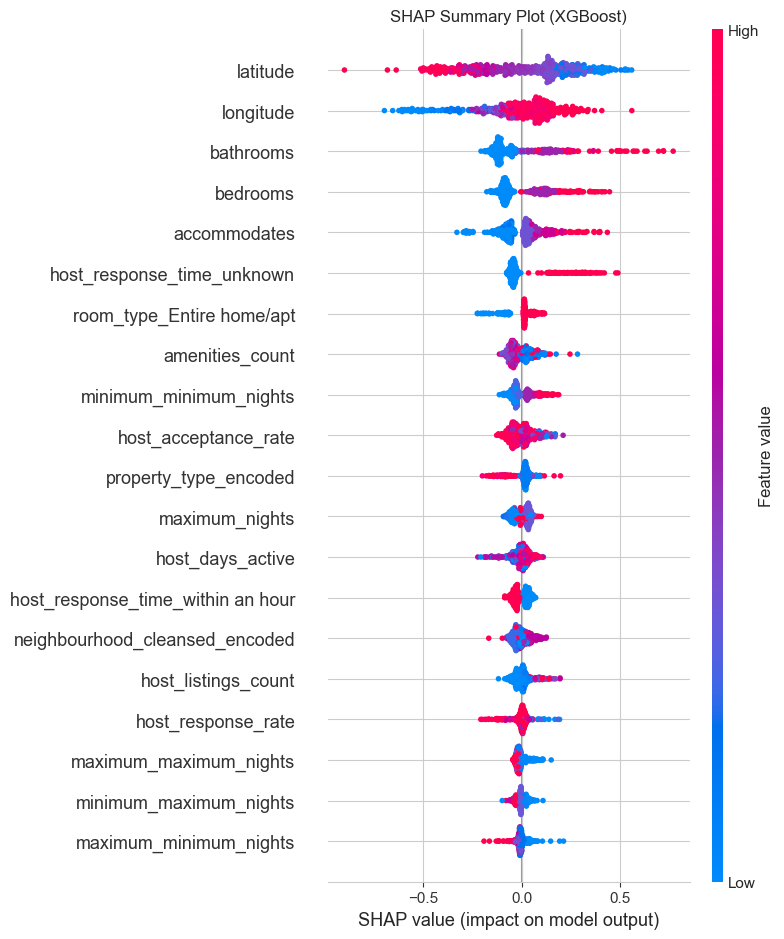

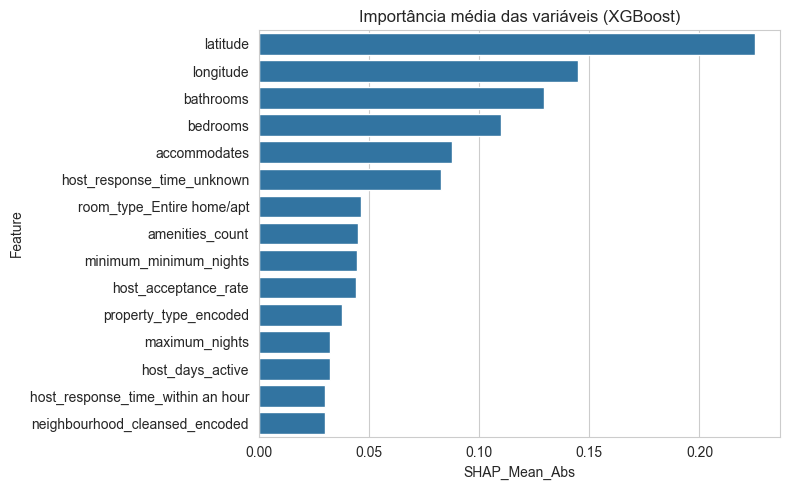

In [21]:
# ==========================================================
# 5. Interpretação com SHAP (versão compatível)
# ==========================================================

if 'Forest' in best_model_name or 'XGB' in best_model_name:
    print("\nGerando SHAP Summary Plot (versão compatível)...")
    X_sample = pd.DataFrame(X_test_scaled, columns=X.columns).sample(n=500, random_state=42)
    explainer = shap.Explainer(best_model, X_sample)
    shap_values = explainer(X_sample)
    
    shap.summary_plot(shap_values.values, X_sample, show=False)
    plt.title(f"SHAP Summary Plot ({best_model_name})")
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.show()

    # Barplot de importância média
    shap_importance = np.abs(shap_values.values).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Mean_Abs': shap_importance
    }).sort_values(by='SHAP_Mean_Abs', ascending=False).head(15)

    plt.figure(figsize=(8,5))
    sns.barplot(x='SHAP_Mean_Abs', y='Feature', data=importance_df)
    plt.title(f"Importância média das variáveis ({best_model_name})")
    plt.tight_layout()
    plt.savefig('shap_feature_importance.png')
    plt.show()
